In [132]:
import numpy as np
from Environment import *
from Learner.UCB_CR import *
import matplotlib.pyplot as plt
from Model.Evaluator.GraphEvaluator import *

In [133]:
def totalMarginPerNodePerUser (envReturn, marginsPerPrice, pulledArm, n_user):
    TotMargin = 0

    for e in envReturn:
        # print("Product: ", e.product,
        #     "Price: ", pulledArm[e.product],
        #    "Units: ", e.units,
        #   "Margin: ", marginsPerPrice[e.product][pulledArm[e.product]] * e.units)
        TotMargin += marginsPerPrice[e.product][pulledArm[e.product]] * e.units
    return TotMargin / n_user

In [134]:
config_path = "Configs/config3.json"
env = Environment(config_path=config_path)

f = open(config_path)
config = json.load(f)
f.close()

margins = config["margins"]
conf_classes = config["classes"]
alphas = np.zeros(5)
clickProb = np.zeros((5,5))
conversionRates = np.zeros((5,4))
unitsMean = np.zeros(5)


Lambda = conf_classes[0]["lambda"]

optimal = config["optimalConfig"]
print(optimal)
optimalConv = [0, 0, 0, 0, 0]
optimalMarg= [0, 0, 0, 0, 0]

totUser = 0
for uc in conf_classes:
    user_mean = uc["usersMean"]
    totUser += user_mean
    alphas +=  np.multiply(uc["alphas"], user_mean)
    clickProb += np.multiply(uc["clickProbability"], user_mean)
    conversionRates += np.multiply(uc["conversionRates"], user_mean)
    unitsMean += np.multiply(uc["unitsShape"], user_mean)
    #productList= [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]

alphas = np.divide(alphas, totUser)
clickProb = np.divide(clickProb, totUser)
conversionRates = np.divide(conversionRates, totUser)
unitsMean = np.divide(unitsMean, totUser)

secondary = []
for key in uc["secondary"]:
    secondary.append(uc["secondary"][key])

productList = [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]

prod=0
for arm in optimal:
    optimalConv[prod] = conversionRates[prod][arm]
    optimalMarg[prod] = margins[prod][arm]
    prod += 1

[1, 1, 1, 1, 1]


In [135]:
graphEval = GraphEvaluator(products_list=productList, click_prob_matrix=clickProb, lambda_prob=Lambda,
                    alphas=alphas, conversion_rates=optimalConv, margins=optimalMarg, units_mean=unitsMean, verbose=False)

optimalConfOptimalMarg = graphEval.computeMargin()
print(optimalConfOptimalMarg)

92.56142857142858


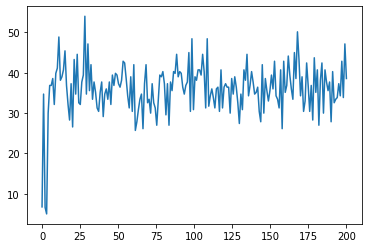

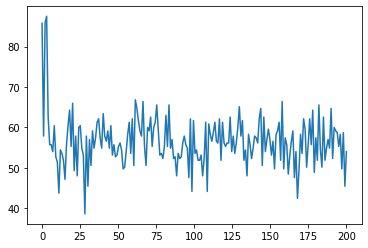

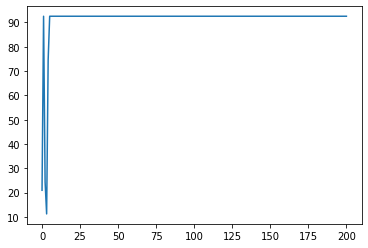

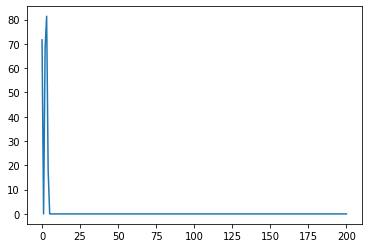

In [136]:
learner = UCB_CR(margins=margins, clickProbability=clickProb, alphas=alphas, secondary=secondary, Lambda=Lambda, debug=False)
#learner = UCB(margins=margins)
n_experiments = 200

list_margins_UCB = []
list_margins_graphEval = []

geConv = [0, 0, 0, 0, 0]
geMArg = [0, 0, 0, 0, 0]

for t in range(0, n_experiments):
    conf = learner.pull_arm()
    #print(conf)
    env.setPriceLevels(conf)
    rew = env.round()
    list_margins_UCB.append(totalMarginPerNodePerUser(rew["episodes"], margins, conf, totUser))

    prod=0
    for arm in conf:
        geConv[prod] = conversionRates[prod][arm]
        geMArg[prod] = margins[prod][arm]
        prod += 1

    graphEval = GraphEvaluator(products_list=productList, click_prob_matrix=clickProb, lambda_prob=Lambda,
                    alphas=alphas, conversion_rates=geConv, margins=geMArg, units_mean=unitsMean, verbose=False)

    list_margins_graphEval.append(graphEval.computeMargin())
    learner.update(rew)

x = np.linspace(0, n_experiments, n_experiments)
fig1, ax1 = plt.subplots()
ax1.plot(x, list_margins_UCB)
fig2, ax2 = plt.subplots()
ax2.plot(x, optimalConfOptimalMarg-list_margins_UCB)
fig3, ax3 = plt.subplots()
ax3.plot(x, list_margins_graphEval)
fig4, ax4 = plt.subplots()
ax4.plot(x, optimalConfOptimalMarg-list_margins_graphEval)

plt.show()